## 4차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [81]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [82]:
import yfinance as yf

# 암호화페도 주식~
crypto = 'XRP-USD'

df = yf.download(crypto, period='5y')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-08,0.275829,0.283569,0.271744,0.278459,0.278459,1518125769
2019-10-09,0.278392,0.283725,0.274915,0.281627,0.281627,1579225264
2019-10-10,0.281551,0.281551,0.268893,0.272073,0.272073,1383555182
2019-10-11,0.272109,0.275936,0.268589,0.271099,0.271099,1265760690
2019-10-12,0.271115,0.278960,0.271074,0.273191,0.273191,1100066310


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [83]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [84]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-04,0.521953,0.538375,0.515728,0.534341,0.534341,1408313543
2024-10-05,0.534317,0.534853,0.526897,0.529496,0.529496,685609430
2024-10-06,0.529497,0.536709,0.528492,0.533592,0.533592,595405724
2024-10-07,0.533592,0.545361,0.529788,0.529934,0.529934,1192453387
2024-10-08,0.529906,0.533863,0.525842,0.527149,0.527149,1051770048


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

종가(close)는 시장이 마감되기 전 마지막으로 거래된 주가를 뜻하는데    
수정 종가(adjusted close)는 해당 주식의 종가(close)에 분할(splits),  
배당금 분배(dividend distributions) 등   주가에 영향을 미칠 수 있는  
기업의 활동(corporate actions)을 반영한 후의 종가를 뜻함  

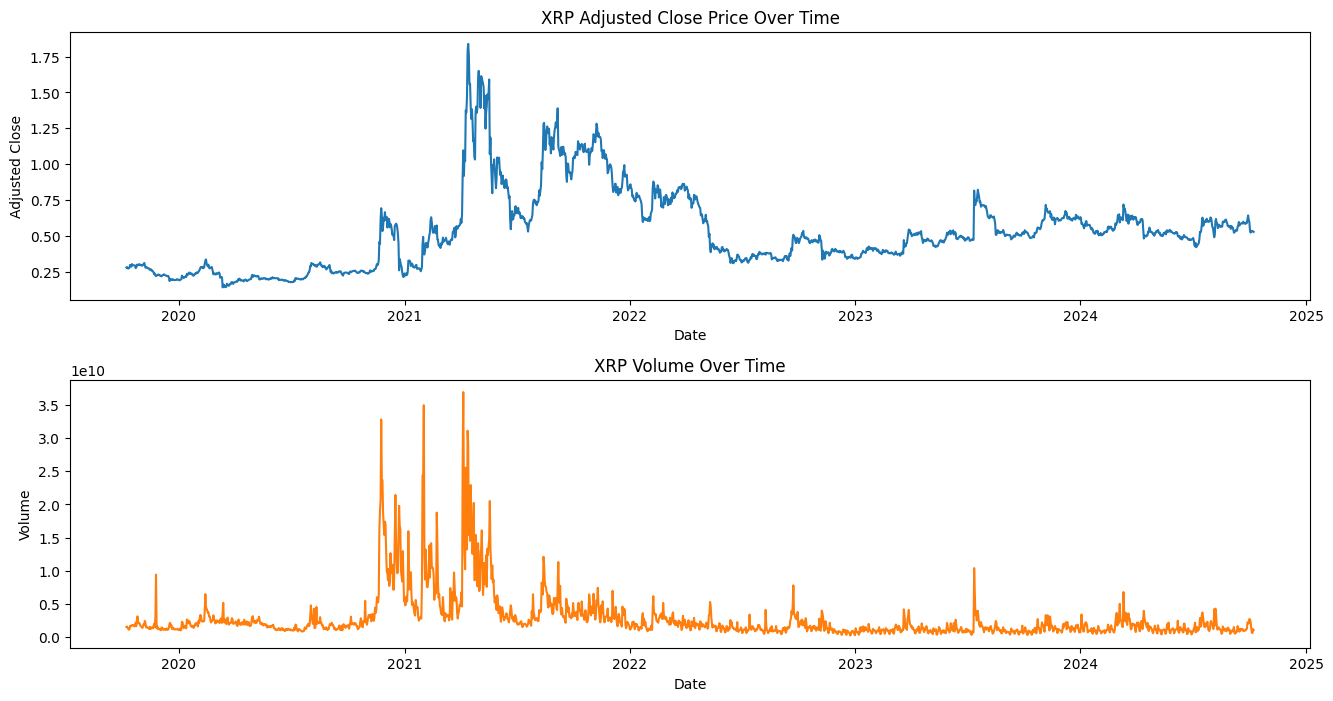

In [85]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# 수정종가 (Adj Close)
ax1.plot(df.index, df['Adj Close'], color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close')
ax1.set_title('XRP Adjusted Close Price Over Time')

# 거래량 (Volume)
ax2.plot(df.index, df['Volume'], color='tab:orange')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.set_title('XRP Volume Over Time')

plt.subplots_adjust(hspace=0.3)
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

20년도말~21년도초 군대에 있던 사람들이 코인을 안할수가 없었던 이유..

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터가 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

--

2.1.1 정상성이란    

정상성은 시계열 데이터가 시점에 따라 평균이나 분산 같은 통계적 특징이 변하지 않으며  
추세나 계절성이 없는 시계열 데이터를 의미

2.1.2 정상성여부 판단을 하는 이유  

시계열 데이터가 비정상성을 띤다면 평균과 분산이 다르기 때문에 임의의 시점 t-1, t에서 얻은 모델은   
t+1~t+n에서 사용할 수 없게 된다. 이는 미래의 값을 예측할 수 없게 됨으로 분석의 유의미함을 위해 정상성여부를 판단

2.1.3 비정상성 해결 방법  

- 추세 차분
- 계절성 차분
- 로그 변환

--

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후  
수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [86]:
adf_result = adfuller(df['Adj Close'])

adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")

ADF Statistic: -3.0407660669350034
p-value: 0.03125878954582526


2.3 ADF Test 결과를 해석하세요.

p-value: 0.03 < 0.05 이므로 귀무가설을 기각할수 있다.   
이는 정상시계열이라고 말할수 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

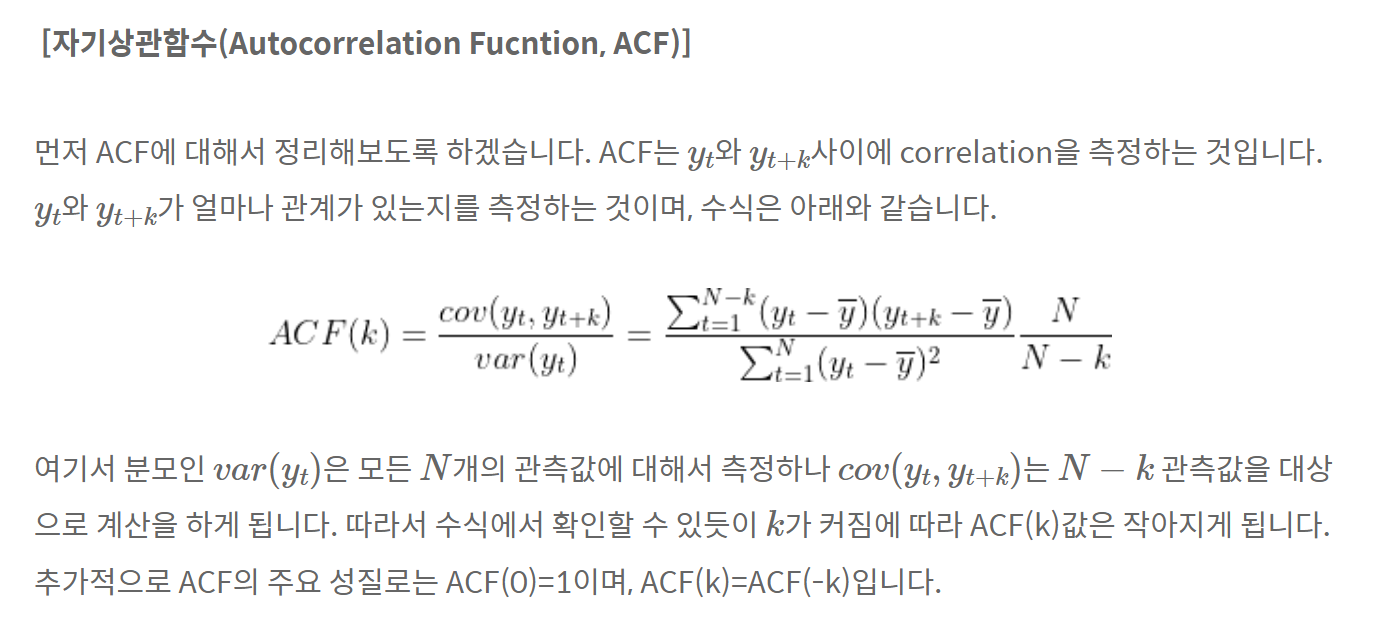

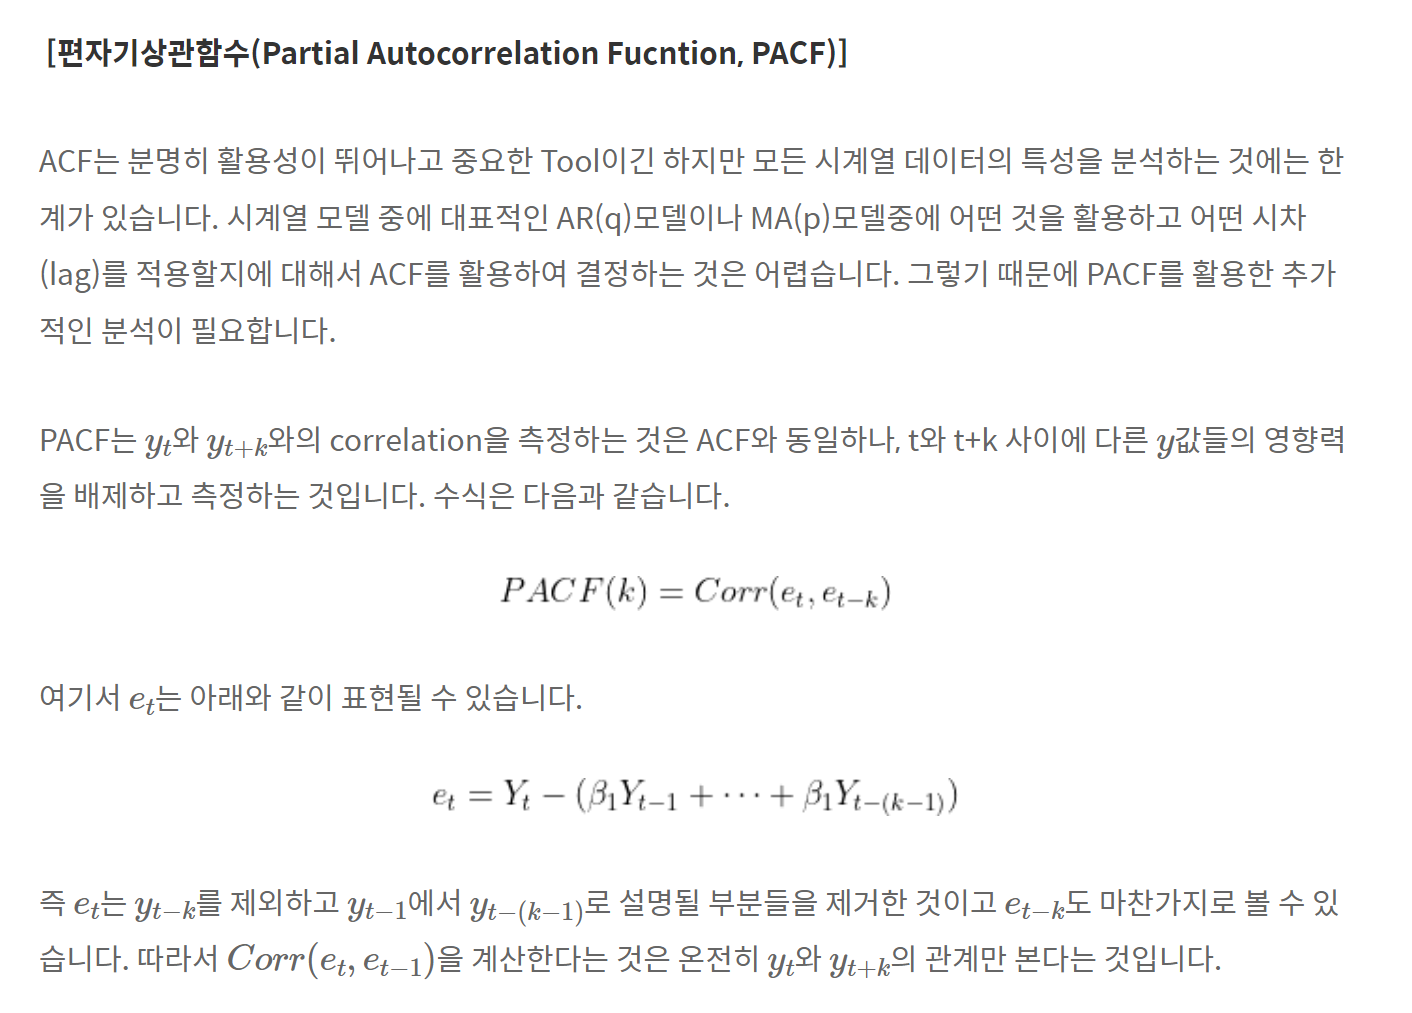

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

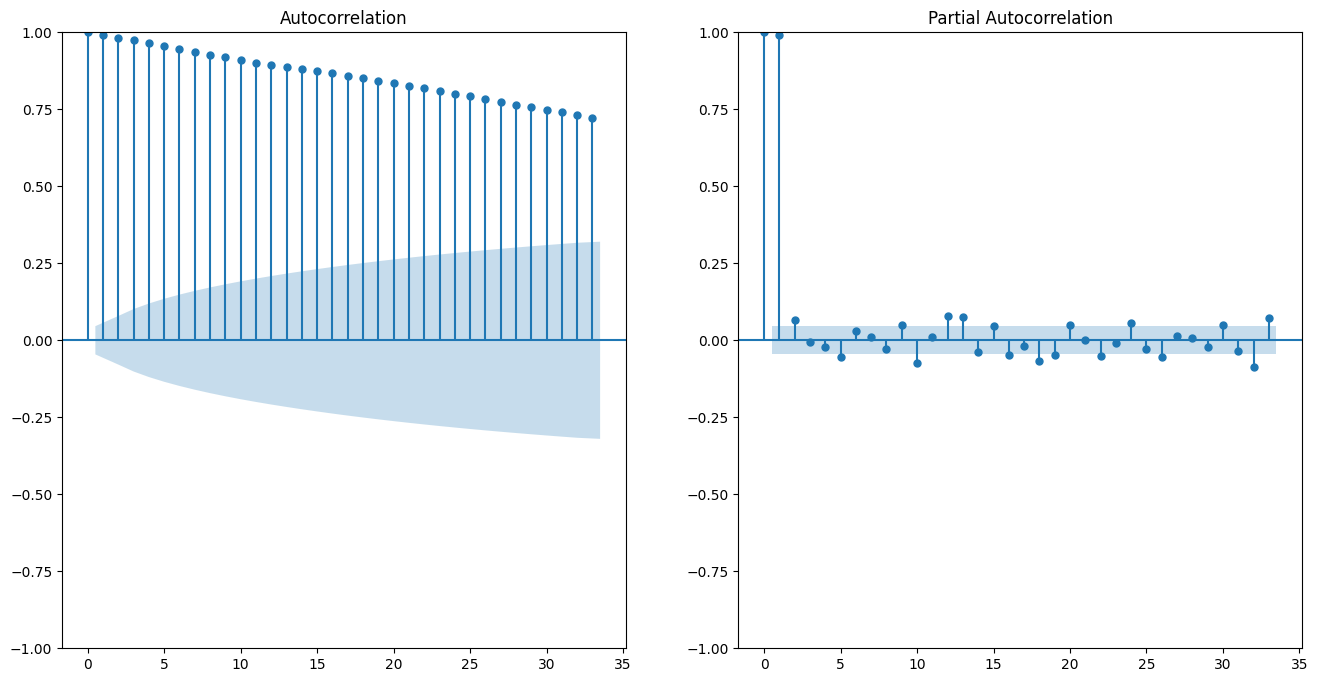

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_acf(df['Adj Close'], ax=ax1)
plot_pacf(df['Adj Close'], method='ywm', ax=ax2)
plt.show()

2.6 결과를 해석하세요.

ACF의 경우 점점 작아지고 있음 (끊기는 모습 x)  
PACF의 경우 첫값으로부터 1개 뒤 끊기는 모습 -> p=1  
=> AR(1) 모형 적절

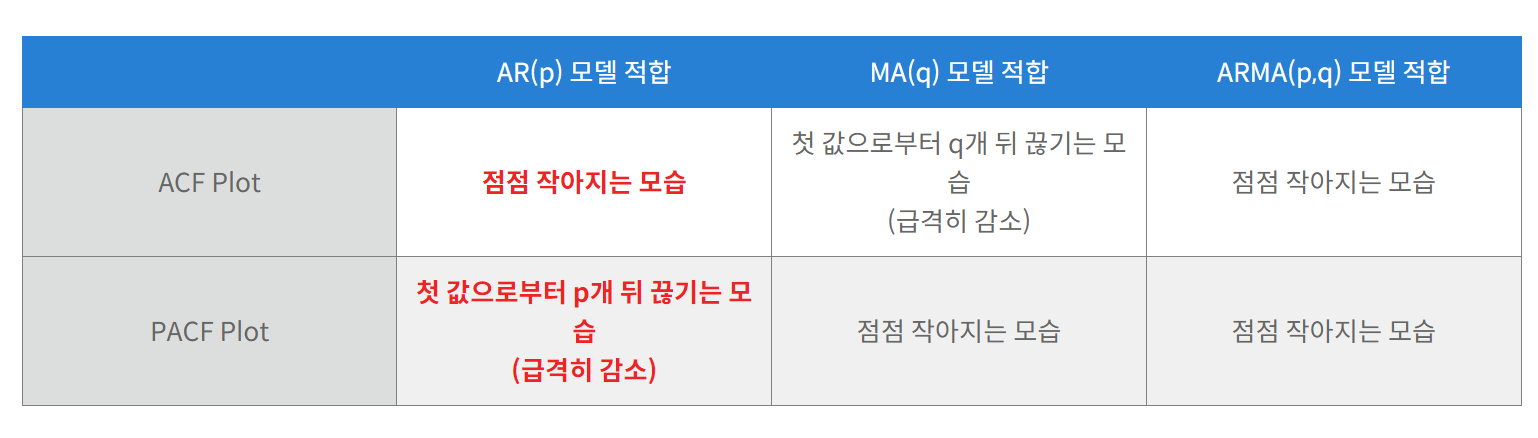

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

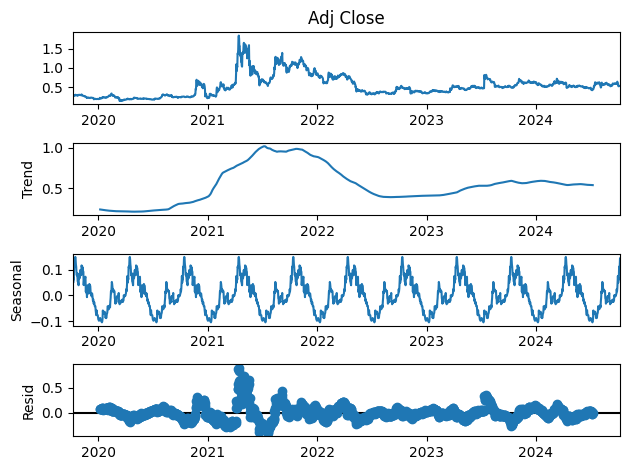

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

season = seasonal_decompose(df['Adj Close'], period = 182) # 365/2 임으로 반년을 주기로 설정한것

fig = season.plot()
plt.show()

2.8 위 결과를 해석하세요.

Observed (관측값): 원본 시계열 데이터  
시계열 데이터의 전체적인 패턴을 보여줌 -> 고양이 귀모양 그리고 상대적으로 완만한 모습

Trend (추세): 시계열 데이터의 장기적인 추세  
데이터의 전반적인 상승 또는 하강 경향을 보여줌 -> 21-22 큰 상승을 보여주고 하강하였다가 23년도 이후로 오르는 추세  

Seasonal (계절성): 시계열 데이터의 주기적인 패턴  
이 플롯은 데이터의 주기적인 변동을 보여줌. 예를 들어, 특정 기간마다 반복되는 패턴을 확인할 수 있습니다.   
-> period = 182(=365/2) 으로 반년을 주기로 설정한 계절성이 나타난것

Residual (잔차): 관측값에서 추세와 계절성을 제거한 후 남은 부분  
데이터의 불규칙한 변동을 보여줌. 잔차가 랜덤하게 분포되어 있으면 모델이 데이터를 잘 설명하고 있다는 것을 의미  

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

보통 현실세계에서의 시계열의 데이터 경우 90%정도가 비정상시계열에 속한다고 하는데  
리플코인은 정상시계열임을 확인함

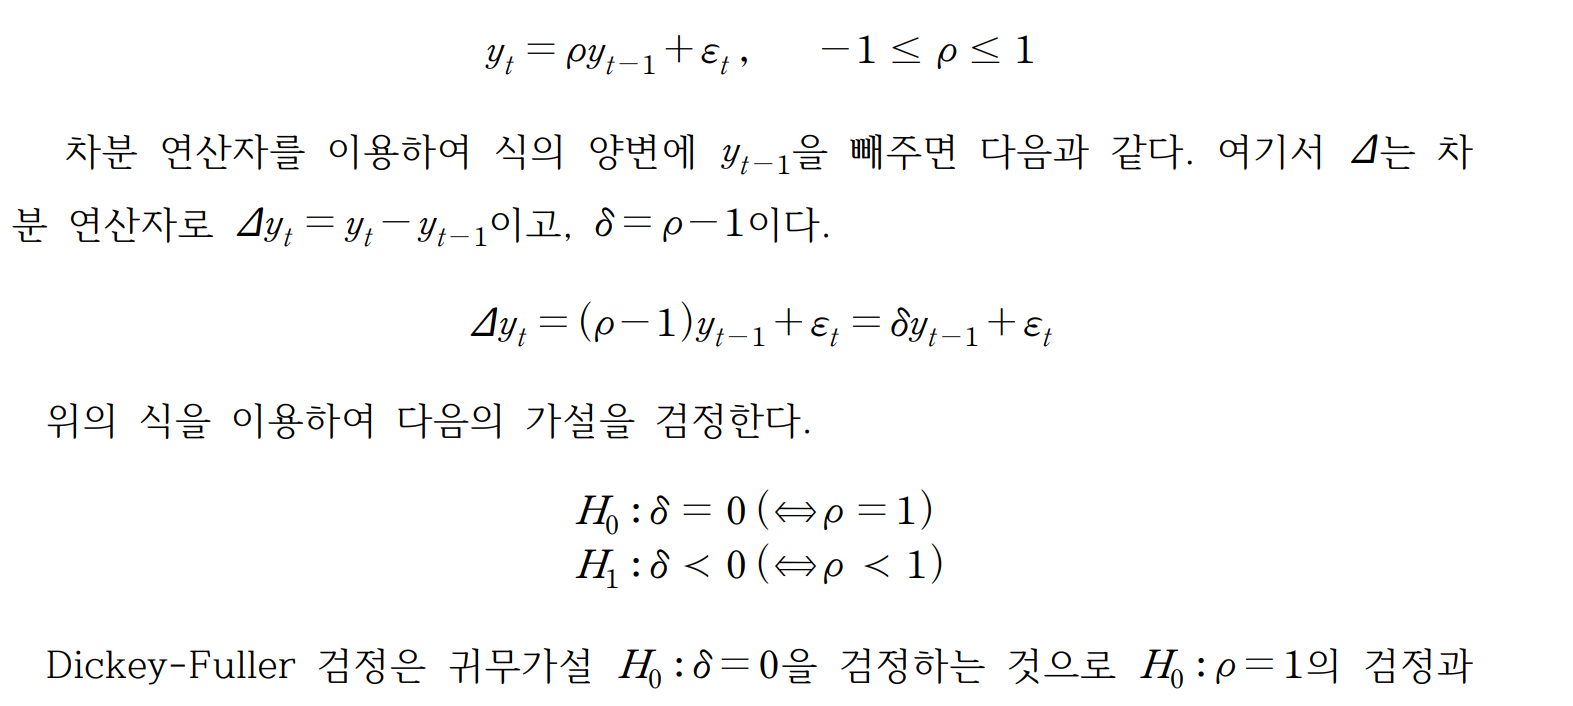

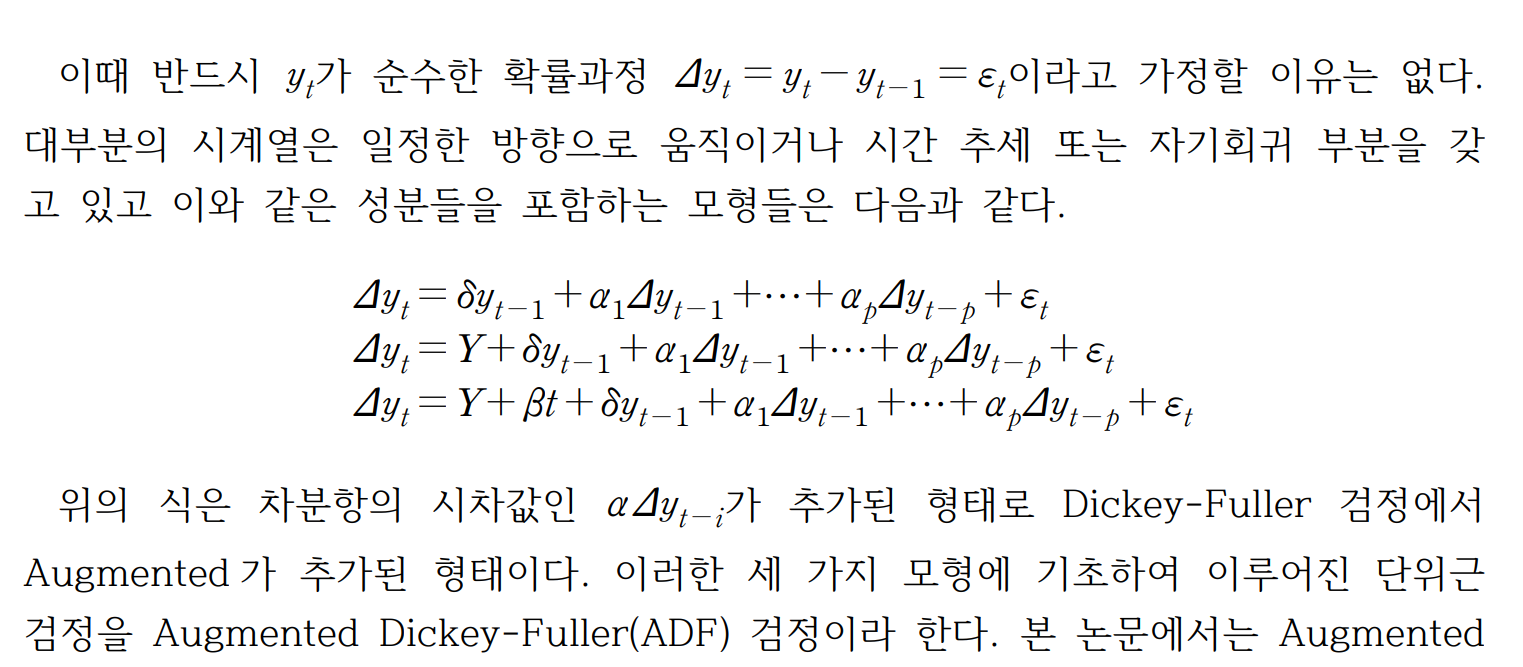

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [89]:
df_diff = df['Adj Close'].diff().dropna()

adf_result_diff = adfuller(df_diff)

adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]

print(f"ADF Statistic after Differencing: {adf_statistic_diff}")
print(f"p-value after Differencing: {p_value_diff}")

ADF Statistic after Differencing: -8.029764462555152
p-value after Differencing: 1.9727251419354727e-12


0.000000000001971923627056607 수치로 유의확률 5%수준으로 보았을때 < 0.05 임으로  
1차 차분한 시계열 또한 비정상시계열임을 확인할수 있다.   

2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

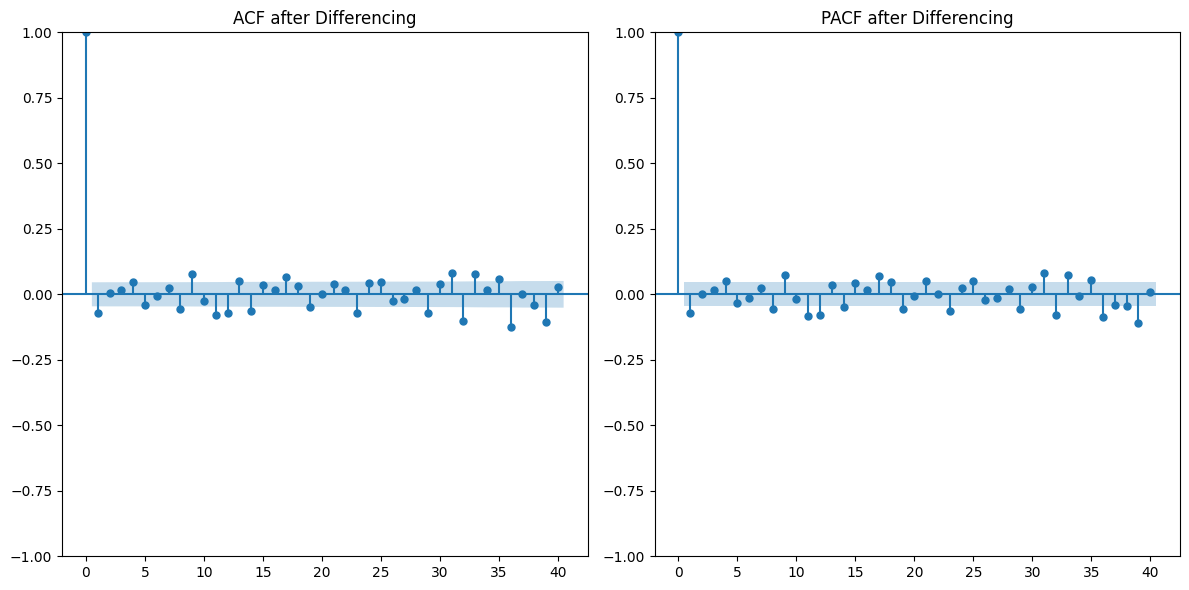

In [90]:
plt.figure(figsize=(12, 6))

# ACF 그래프
plt.subplot(1, 2, 1)
plot_acf(df_diff, ax=plt.gca(), lags=40)
plt.title('ACF after Differencing')

# PACF 그래프
plt.subplot(1, 2, 2)
plot_pacf(df_diff, ax=plt.gca(), lags=40)
plt.title('PACF after Differencing')

plt.tight_layout()
plt.show()

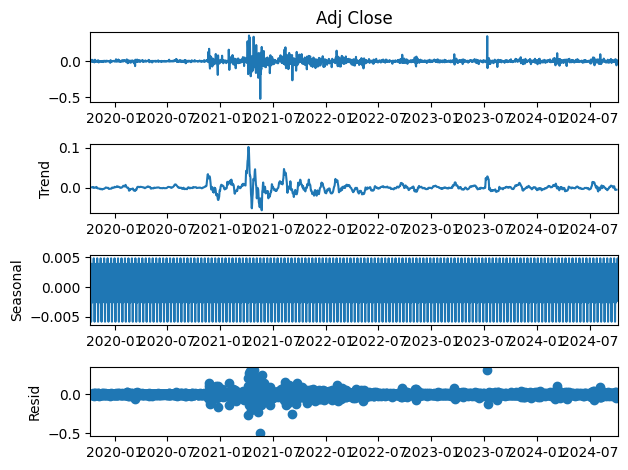

In [91]:
decomposition = seasonal_decompose(df_diff, period=12)

decomposition.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [92]:
from statsmodels.tsa.arima.model import ARIMA

In [93]:
df['Adj Close']

Date
2019-10-08    0.278459
2019-10-09    0.281627
2019-10-10    0.272073
2019-10-11    0.271099
2019-10-12    0.273191
                ...   
2024-10-04    0.534341
2024-10-05    0.529496
2024-10-06    0.533592
2024-10-07    0.529934
2024-10-08    0.527149
Name: Adj Close, Length: 1828, dtype: float64

In [94]:
import warnings
import statsmodels.api as sm

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

# ARIMA 모델 생성 및 학습
model = sm.tsa.ARIMA(df['Adj Close'], order=(1, 0, 0))  # AR(1) 모델
model_fit = model.fit()

# 모델 요약 출력
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1828
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3371.607
Date:                Tue, 08 Oct 2024   AIC                          -6737.214
Time:                        22:26:07   BIC                          -6720.681
Sample:                    10-08-2019   HQIC                         -6731.116
                         - 10-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5267      0.135      3.915      0.000       0.263       0.790
ar.L1          0.9902      0.002    441.007      0.000       0.986       0.995
sigma2         0.0015   1.16e-05    125.591      0.0

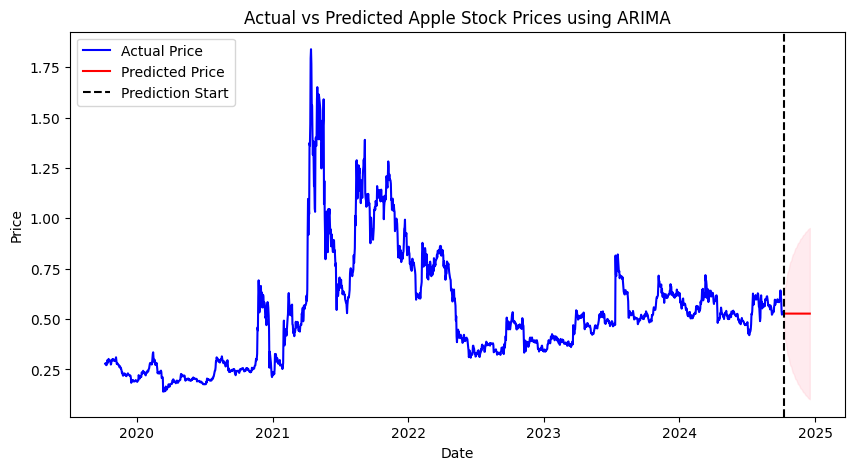

In [95]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Adj Close'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=df.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [96]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(crypto, start='2024-07-01', end='2024-10-01')
actual_last_50 = actual_data_last_50[['Close']]

[*********************100%%**********************]  1 of 1 completed

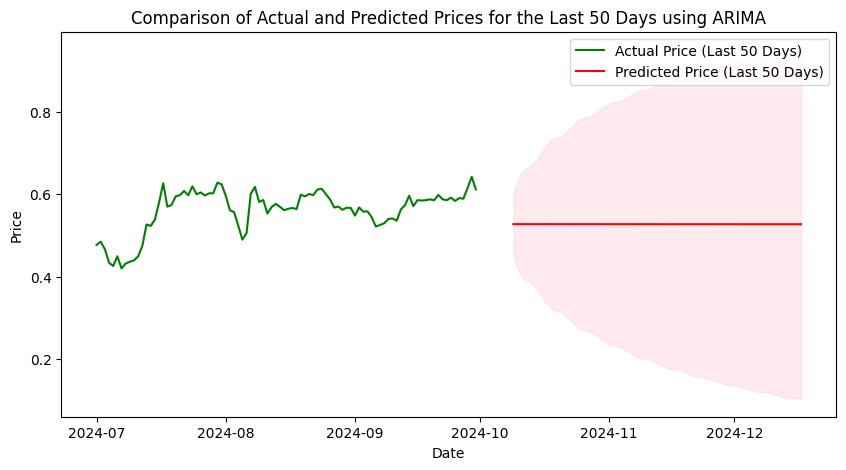

In [97]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [98]:
# %pip install prophet

In [99]:
from prophet import Prophet

In [100]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###

crypto = 'XRP-USD'
data = yf.download(crypto, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed

In [101]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

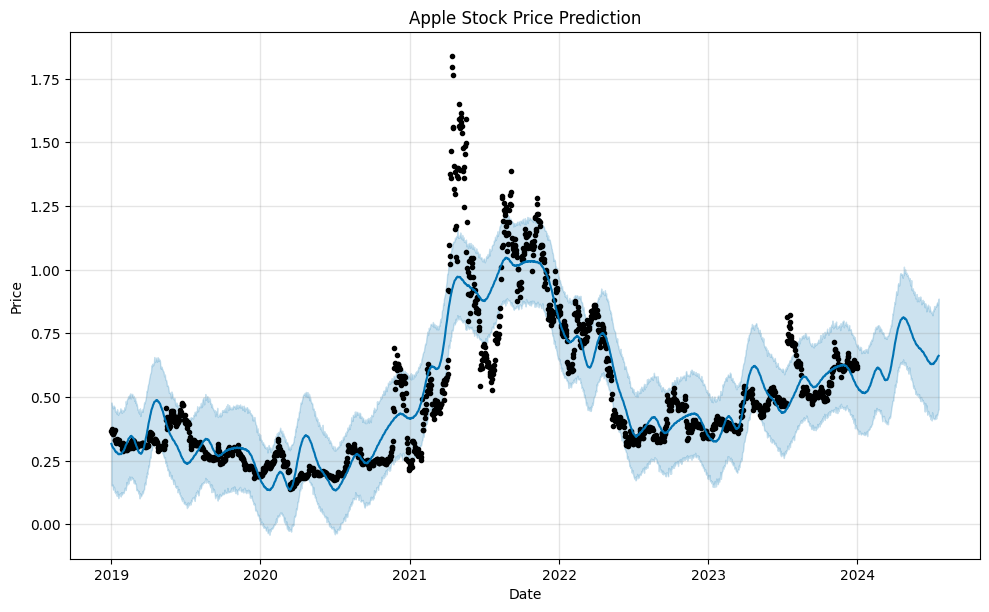

In [103]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

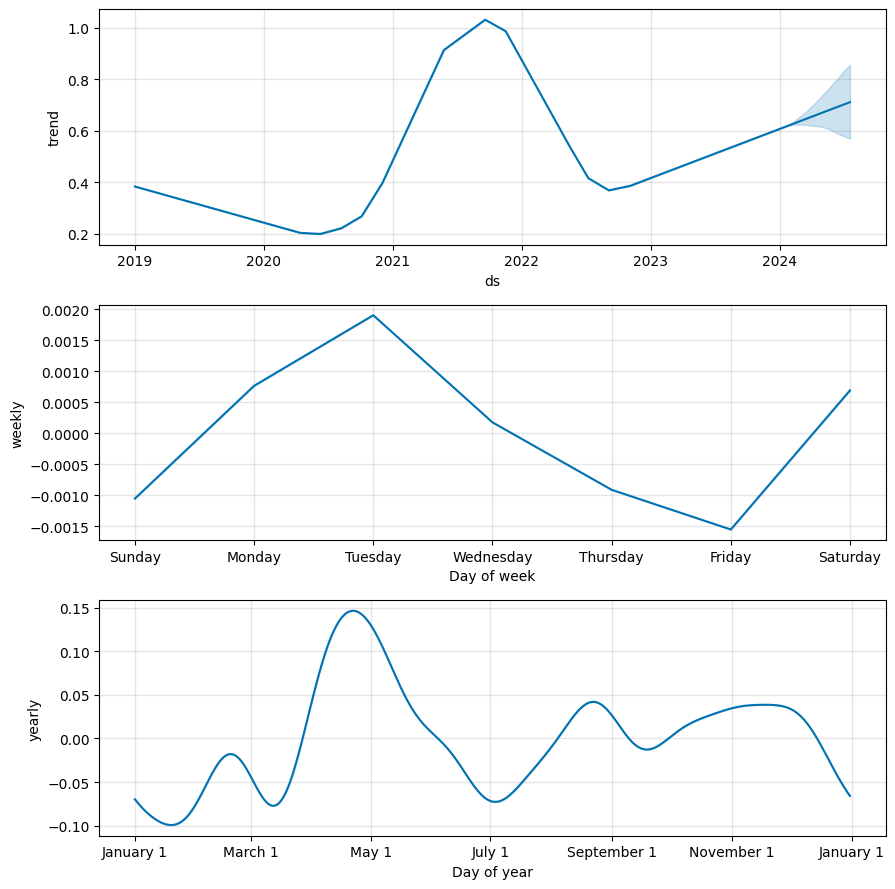

In [104]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [105]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(crypto, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed

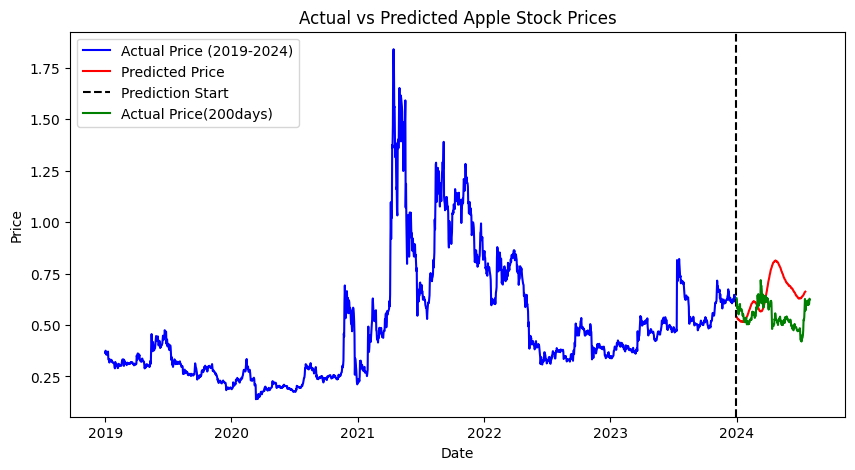

In [106]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

.